<h1>CSPB 3202 Final Project</h1>
<h4>By Patrick Chesnut</h4>
<span>GitHub: </span><a style="color:CornflowerBlue"><u>https://github.com/chesnutpc/CSPB3202FinalProject</u></a>

<h2>1. Project Overview</h2>

In this project, I tackle the Mountain Car problem using reinforcement learning techniques, specifically designed to navigate a car from the bottom of a valley to the top of a hill. The challenge lies in the fact that the car's engine is not powerful enough to reach the summit directly; instead, the solution involves skillfully using momentum by oscillating the car between both sides of the valley. This strategic approach requires an understanding of how to build and leverage momentum to eventually reach the goal.

To conduct this study, I utilized the Kaggle environment to leverage GPU resources, as I do not have access to a personal computer equipped with such hardware. For implementing the reinforcement learning models, I used the RLlib library in conjunction with TensorFlow. The focus of the project involves comparing the performance of three distinct algorithms: Asynchronous Proximal Policy Optimization (APPO), Proximal Policy Optimization (PPO), and Deep Q Networks (DQN). By evaluating these algorithms, the goal is to determine which approach most effectively trains the agent to solve the Mountain Car problem, balancing exploration and exploitation to successfully navigate the challenging terrain.

The code block below installs all of the necessary packages.


In [2]:
# %%capture #supresses output
!pip install gymnasium==0.29.0
!pip install pygame 
!pip install swig 
# !pip install ale-py
# !pip install shimmy
!pip install "gymnasium[box2d]" 
# !pip install "gymnasium[other]" 
!pip install tensorflow
!pip install ray[rllib]
import ray
from ray import tune
# import ale_py
# import shimmy
import gymnasium as gym


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 80.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.9 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=495184 sha256=7e66d9e6d1b7d8709ebb06769d75ab8b124f5dfef97e23df72663b21a15a0059
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.0 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depende

2024-08-12 08:35:40,997	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-12 08:35:42,248	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


<h2>2. Environment/Game Rules</h2>

The Mountain Car environment presents a reinforcement learning challenge with specific observation and action spaces. The observation space comprises two continuous parameters: the car's position along the x-axis and its velocity. The x-axis position ranges from -1.2 to 0.6, indicating the car’s location within the valley, while the velocity represents the car's speed in the x-direction. Both of these continuous variables provide the agent with crucial information about its current state within the environment.

The action space in the Mountain Car problem is discrete, consisting of three distinct actions: accelerate to the left, do nothing, and accelerate to the right. These actions are binary, meaning each action is a single choice among the three available options, allowing the agent to control the car's movement in a straightforward manner.

The game can conclude in one of two scenarios. The primary goal is to move the car to the top of the right hill, which is achieved when the car's x-axis position equals 0.5. Alternatively, the game ends if 200 time steps are reached without accomplishing this objective. During gameplay, each time step incurs a reward of -1, and there is no additional reward for reaching the top of the hill. Consequently, to maximize the reward function, the agent must focus on minimizing the time it takes to reach the summit by efficiently navigating the valley and building momentum.


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [4]:
def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render())
    plt.title("%s | Step: %d %s" % (env.spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [5]:
import gymnasium as gym

env = gym.make("MountainCar-v0", render_mode='rgb_array')

total_reward = 0.0
total_steps = 0
obs = env.reset()
print(obs)
env.observation_space
# Box in output means that elements are continuous
# (2,) indicates the shape of the numpy array, vector with 2 dimensions
# The first element gives the lower range, the second element gives the upper range
# The data type of the elements are float32



(array([-0.47480312,  0.        ], dtype=float32), {})


Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

| Number | Observation               | Min   | Max |
|--------|---------------------------|-------|-----|
| 0      | X-axis position           | -1.2  | 0.6 |
| 1      | Velocity of car           | -0.07 |0.07 |


In [6]:
env.action_space
# Discrete(3) indicates shape of numpy array, vector with 3 dimensions
# all take on values of either 0 or 1

Discrete(3)

| Number | Description                |
|--------|----------------------------|
| 0      | Accelerate to the left     |
| 1      | Don't accelerate           |
| 2      | Accelerate to the right    |


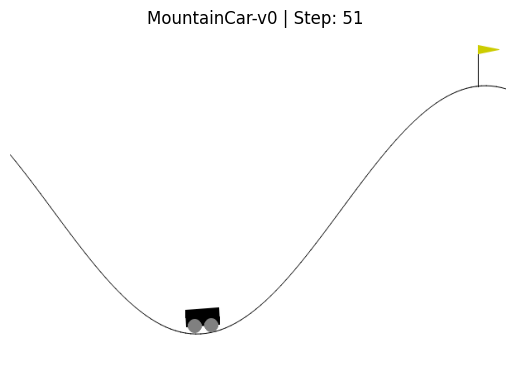

Episode done in 51 steps, total reward -51.00


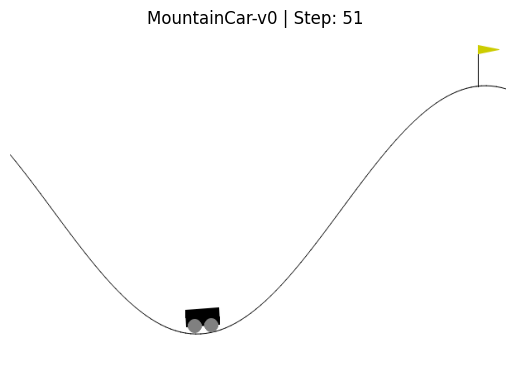

In [9]:
# Simulating a random agent
# obs gives the next environment state
# reward gives the reward for the step
# done is bool indicating if game is over

# Initalize variables
obs = env.reset()
total_reward = 0
total_steps = 0

while True:
    action = env.action_space.sample() # random agent
    obs, reward, done, _, _ = env.step(action)
    total_reward += reward
    total_steps += 1
    show_state(env,total_steps)
    if total_steps > 50:
        break
    if done:
        break


print("Episode done in %d steps, total reward %.2f" % (total_steps, total_reward))
env.close()
# env.env.close()

In [1]:
# Here is a short video of the random agent.
from IPython.display import Video
Video("MountainCarRandomAgent.mp4")


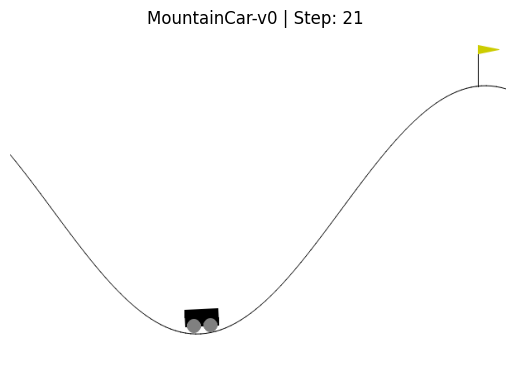

Average total reward for 5 episodes: -21.00


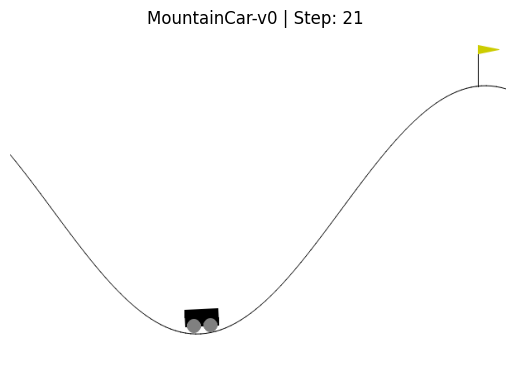

In [11]:
# Now we modify the code above to complete multiple episodes and compute the average total_reward
ep = 0
total_reward_list = []
for ep in range(5):
    # Initalize variables
    obs = env.reset()
    total_reward = 0
    total_steps = 0
    while True:
        action = env.action_space.sample() # random agent
        obs, reward, done, _, _ = env.step(action)
        total_reward += reward
        total_steps += 1
        show_state(env,total_steps)
        if total_steps > 20:
            total_reward_list.append(total_reward)
            break
        if done:
            total_reward_list.append(total_reward)
            break

print("Average total reward for %d episodes: %.2f" % (ep+1, sum(total_reward_list) / len(total_reward_list)))
env.close()


In [2]:
# Here is another short video of 5 trials of the random agent.
# I have truncated each episode to 21 steps here.
Video("MountainCarRandomAgent5Trials.mp4")


Here is a summary of documentation available from the Gymnasium webpage [ref1]

<h5>Starting State</h5>
The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.

<h5>Reward Function</h5>
The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is penalised with a reward of -1 for each timestep.


<h5>Episode End</h5>
The episode ends if either of the following happens:<br>

Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)

Truncation: The length of the episode is 200.

<h2>3. Reinforcement Models</h2>
As stated in the introduction this project will use RLlib and TensorFlow. RLlib is an open-source library developed by Ray that provides scalable and versatile implementations of various reinforcement learning algorithms [Ref2]. It simplifies the process of training and evaluating reinforcement learning models by offering high-level abstractions and support for distributed training.  TensorFlow, on the otherhand, is used by RLlib to deploy the reinforcement models.  This project will use Asynchronous Proximal Policy Optimization (APPO), Proximal Policy Optimization (PPO), and Deep Q Networks (DQN) [Ref3].


In [11]:
# Initialize RAY
ray.init()


2024-08-12 02:56:16,576	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.9.0


<h3>3a. Asynchronous Proximal Policy Optimization (APPO)</h3>

The first model I trained used APPO. It operates by training multiple agents in parallel across different environments, each independently updating a shared global policy. This parallelization allows APPO to leverage diverse experiences and reduce the correlation between updates, leading to more robust and faster learning.

Although it trained for 1 hour and 20 minutes, it was never able to successfully solve the problem as shown by the episode_reward_max being -200 indicating that all games ended by reaching the time limit.


In [9]:
# To run experiment you need:
# 1. A RL environment (MountainCar)
# 2. A RL algorithm (Approximate Proximal Policy Optimization)
# 3. Configuration (algo config, experiment config, env config)
# 4. An experiment runner (tune in Ray)

from ray import tune
tune.run("APPO",
         config={"env": "MountainCar-v0",
                 # other configurations can be specified here
                 # can change training phase with evaluation_interval
                 # "evaluation_interval": 2,
                 # can change evaluation phasae with evaluation_num_episodes
                 # "evaluation_duration": 20,
                 "framework": "tf",
                 "num_gpus": 1,
                 "storage_path": "./results",
                },
#          run_config=RunConfig(storage_path="./results", name="DQN_experiment")
        )

2024-08-12 08:44:34,235	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(pid=691) 2024-08-12 08:44:36.107623: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=691) 2024-08-12 08:44:36.107685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=691) 2024-08-12 08:44:36.109101: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=723) 2024-08-12 08:45:21.636097: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=723) 2024-08-12 08:45:21.636159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to reg

Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,info,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,timers
APPO_MountainCar-v0_19708_00000,4757200,"{'ObsPreprocessorConnector_ms': 0.00824427604675293, 'StateBufferConnector_ms': 0.00691986083984375, 'ViewRequirementAgentConnector_ms': 0.17692875862121582}","{'num_env_steps_sampled': 4757200, 'num_env_steps_trained': 4757000, 'num_agent_steps_sampled': 4757200, 'num_agent_steps_trained': 4757000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'last_target_update_ts': 4757200, 'num_weight_broadcasts': 93446, 'num_target_updates': 93446, 'num_samples_added_to_queue': 4757000}",{},200,{},-200,-200,-200,50,"{'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'total_loss': -0.011634342, 'policy_loss': -0.0006537969, 'entropy': 1.0986117, 'var_gnorm': 28.775139, 'vf_loss': 1.1143215e-05, 'vf_explained_var': -0.43242085, 'entropy_coeff': 0.009999999776482582, 'mean_IS': 1.0000029, 'var_IS': 2.5641956e-08, 'model': {}, 'grad_gnorm': [0.0054105907]}, 'train': None, 'num_grad_updates_lifetime': 9514.0, 'diff_num_grad_updates_vs_sampler_policy': 0.3999999999996362}}, 'num_env_steps_sampled': 4757200, 'num_env_steps_trained': 4757000, 'num_agent_steps_sampled': 4757200, 'num_agent_steps_trained': 4757000, 'num_training_step_calls_since_last_synch_worker_weights': 0, 'last_target_update_ts': 4757200, 'num_weight_broadcasts': 93446, 'num_target_updates': 93446, 'num_samples_added_to_queue': 4757000, 'learner_queue': {'size_count': 9514, 'size_mean': 0.0, 'size_std': 0.0, 'size_quantiles': [0.0, 0.0, 0.0, 0.0, 0.0]}, 'timing_breakdown': {'learner_grad_time_ms': 16.664, 'learner_load_time_ms': 4.152, 'learner_load_wait_time_ms': 469.737, 'learner_dequeue_time_ms': 8005.584}}",4757200,4757000,4757200,10050,1004.41,4757000,10000,999.414,0,2,3,0,10000,"{'cpu_util_percent': 79.67333333333333, 'ram_util_percent': 14.71333333333333}",{},{},{},"{'mean_raw_obs_processing_ms': 0.5370082168442081, 'mean_inference_ms': 0.9817808631960596, 'mean_action_processing_ms': 0.20757386749156903, 'mean_env_wait_ms': 0.10749102846062929, 'mean_env_render_ms': 0.0}","{'episode_reward_max': -200.0, 'episode_reward_min': -200.0, 'episode_reward_mean': -200.0, 'episode_len_mean': 200.0, 'episode_media': {}, 'episodes_this_iter': 50, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0, -200.0], 'episode_lengths': [200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 

2024-08-12 10:05:26,217	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-08-12 10:05:27,690	INFO tune.py:1042 -- Total run time: 4853.46 seconds (4851.97 seconds for the tuning loop).
2024-08-12 10:05:27,692	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)


<h3>3b. Proximal Policy Optimization (PPO)</h3>

The second model I trained used PPO. It is a reinforcement learning algorithm designed to optimize policies while maintaining stability and avoiding large, destabilizing updates. PPO achieves this by using a surrogate objective function that includes a clipping mechanism to constrain the policy update, ensuring that changes to the policy are not too drastic. This clipping helps prevent the policy from deviating too far from the current one, which can otherwise lead to poor performance or instability. In contrast to Asynchronous Proximal Policy Optimization (APPO), which trains multiple agents asynchronously across different environments, PPO typically trains a single agent or a set of agents synchronously within the same environment.

As can seen from the output below, this algorithm was successful in solving the problem. After 57 minutes of training, the average reward increased to -120, an improvement of 80 timesteps.



In [13]:
# To run experiment you need:
# 1. A RL environment (MountainCar)
# 2. A RL algorithm (Proximal Policy Optimization)
# 3. Configuration (algo config, experiment config, env config)
# Here I use Proximal Policy Optimization (PPO)
# 4. An experiment runner (tune in Ray)

from ray import tune
tune.run("PPO",
         config={"env": "MountainCar-v0",
                 # other configurations can be specified here
                 # can change training phase with evaluation_interval
                 # "evaluation_interval": 2,
                 # can change evaluation phasae with evaluation_num_episodes
                 # "evaluation_duration": 20,
                 "framework": "tf",
                 "num_gpus": 1,
                }
        )
         


2024-08-12 03:09:06,923	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(pid=695) 2024-08-12 03:09:08.659711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=695) 2024-08-12 03:09:08.659776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=695) 2024-08-12 03:09:08.661225: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=725) 2024-08-12 03:09:47.585292: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=725) 2024-08-12 03:09:47.585348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to reg

Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,info,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,timers
PPO_MountainCar-v0_3ca06_00000,1260000,"{'ObsPreprocessorConnector_ms': 0.0096435546875, 'StateBufferConnector_ms': 0.005768537521362305, 'ViewRequirementAgentConnector_ms': 0.1531229019165039}","{'num_env_steps_sampled': 1260000, 'num_env_steps_trained': 1260000, 'num_agent_steps_sampled': 1260000, 'num_agent_steps_trained': 1260000}",{},119.99,{},-86,-119.99,-200,34,"{'learner': {'default_policy': {'learner_stats': {'cur_kl_coeff': 0.20000000298023224, 'cur_lr': 4.999999873689376e-05, 'total_loss': 9.733909, 'policy_loss': -0.01796662, 'vf_loss': 9.751443, 'vf_explained_var': -0.25982043, 'kl': 0.0021662484, 'entropy': 0.15729761, 'entropy_coeff': 0.0, 'model': {}}, 'train': None, 'num_grad_updates_lifetime': 292485.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 1260000, 'num_env_steps_trained': 1260000, 'num_agent_steps_sampled': 1260000, 'num_agent_steps_trained': 1260000}",1260000,1260000,1260000,4000,586.431,1260000,4000,586.431,0,2,0,0,4000,"{'cpu_util_percent': 49.410000000000004, 'ram_util_percent': 13.7}",{},{},{},"{'mean_raw_obs_processing_ms': 0.44006435803723937, 'mean_inference_ms': 0.8794096869256043, 'mean_action_processing_ms': 0.18546615072742817, 'mean_env_wait_ms': 0.09303197436787007, 'mean_env_render_ms': 0.0}","{'episode_reward_max': -86.0, 'episode_reward_min': -200.0, 'episode_reward_mean': -119.99, 'episode_len_mean': 119.99, 'episode_media': {}, 'episodes_this_iter': 34, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-113.0, -118.0, -123.0, -117.0, -115.0, -171.0, -120.0, -122.0, -99.0, -118.0, -119.0, -114.0, -99.0, -126.0, -114.0, -113.0, -194.0, -123.0, -119.0, -123.0, -117.0, -119.0, -117.0, -117.0, -110.0, -88.0, -116.0, -114.0, -119.0, -200.0, -115.0, -115.0, -118.0, -121.0, -119.0, -117.0, -98.0, -96.0, -117.0, -111.0, -115.0, -120.0, -118.0, -119.0, -116.0, -115.0, -112.0, -132.0, -120.0, -129.0, -117.0, -117.0, -86.0, -124.0, -117.0, -117.0, -116.0, -151.0, -118.0, -122.0, -118.0, -99.0, -118.0, -117.0, -115.0, -118.0, -169.0, -117.0, -98.0, -116.0, -117.0, -115.0, -117.0, -118.0, -116.0, -135.0, -118.0, -156.0, -97.0, -118.0, -112.0, -117.0, -132.0, -171.0, -104.0, -171.0, -99.0, -118.0, -96.0, -159.0, -117.0, -114.0, -118.0, -119.0, -94.0, -118.0, -113.0, -92.0, -170.0, -88.0], 'episode_lengths': [113, 118, 123, 117, 115, 171, 120, 122, 99, 118, 119, 114, 99, 126, 114, 113, 194, 123, 119, 123, 117, 119, 117, 117, 110, 88, 116, 114, 119, 200, 115, 115, 118, 121, 119, 117, 98, 96, 117, 111, 115, 120, 118, 119, 116, 115, 112, 132, 120, 129, 117, 117, 86, 124, 117, 117, 116, 151, 118, 122, 118, 99, 118, 117, 115, 118, 169, 117, 98, 116, 117, 115, 117, 118, 116, 135, 118, 156, 97, 118, 112, 117, 132, 171, 104, 171, 99, 118, 96, 159, 117, 114, 118, 119, 94, 118, 113, 92, 170, 88]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 0.44006435803723937, 'mean_inference_ms': 0.8794096869256043, 'mean_action_processing_ms': 0.18546615072742817, 'mean_env_wait_ms': 0.09303197436787007, 'mean_env_render_ms': 0.0}, 'num_faulty_episodes': 0, 'connector_metrics': {'ObsPreprocessorConnector_ms': 0.0096435546875, 'StateBufferConnector_ms': 0.005768537521362305, 'ViewRequirementAgentConnector_ms': 0.1531229019165039}}","{'training_iteration_time_ms': 6998.625, 'sam

2024-08-12 04:05:59,506	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-08-12 04:06:09,553	INFO tune.py:1042 -- Total run time: 3422.63 seconds (3412.57 seconds for the tuning loop).
2024-08-12 04:06:09,559	WARNING tune.py:1057 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)


<h3>3c. Deep Q Networks (DQN)</h3>
The final model I trained used DQN.  It is a reinforcement learning algorithm that extends traditional Q-learning by leveraging deep neural networks to approximate the Q-value function, which estimates the expected reward of taking a specific action in a given state. This approach enables DQN to handle high-dimensional state spaces, such as those encountered in complex environments. DQN utilizes techniques like experience replay, where past experiences are stored in a replay buffer and sampled randomly to break correlations between consecutive experiences, and target networks, which stabilize training by using a separate network to generate the target Q-values. <br><br>

From the output below, note that after only 30 minutes of training it reached the same average reward of the second model (-120).


In [15]:
from ray import tune
tune.run("DQN",
         config={"env": "MountainCar-v0",
                 # other configurations can be specified here
                 # can change training phase with evaluation_interval
                 # "evaluation_interval": 2,
                 # can change evaluation phasae with evaluation_num_episodes
                 # "evaluation_duration": 20,
                 "framework": "tf",
                 "num_gpus": 1,
                 "storage_path": "./results",
                },
#          run_config=RunConfig(storage_path="./results", name="DQN_experiment")
        )


2024-08-12 07:36:54,564	INFO worker.py:1724 -- Started a local Ray instance.
2024-08-12 07:36:55,828	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2024-08-12 07:36:55,834	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-08-12 07:36:57.759118: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 07:36:57.759253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 07:36:57.892955: E external/local_xla/xla/stream_executor/cuda/cuda_blas.c

(pid=821) 2024-08-12 07:37:49.889269: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=821) 2024-08-12 07:37:49.889327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=821) 2024-08-12 07:37:49.890799: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(DQN pid=821) 2024-08-12 07:38:27,840	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/simple_q/` has been deprecated. Use `rllib_contrib/simple_q/` instead. This will raise an error in the future!
(DQN pid=821) Install gputil for GPU system monitoring.


Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,info,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,timers
DQN_MountainCar-v0_c53ee_00000,60000,"{'ObsPreprocessorConnector_ms': 0.007486104965209961, 'StateBufferConnector_ms': 0.005586862564086914, 'ViewRequirementAgentConnector_ms': 0.14931845664978027}","{'num_env_steps_sampled': 60000, 'num_env_steps_trained': 1888000, 'num_agent_steps_sampled': 60000, 'num_agent_steps_trained': 1888000, 'last_target_update_ts': 59501, 'num_target_updates': 118}",{},119.56,{},-84,-119.56,-200,8,"{'learner': {'default_policy': {'learner_stats': {'cur_lr': 0.0005000000237487257, 'mean_q': -45.934616, 'min_q': -66.60256, 'max_q': -2.9433296, 'mean_td_error': 0.119781755, 'model': {}}, 'td_error': array([ 0.1787262 , 0.14273643, 0.3707652 , 0.0442667 , 0.22458649, -0.05362701, 0.17427063, -0.05807495, -0.14471245, 0.91041183, 0.2217865 , -0.05713654, 0.14128399, 0.0233078 , 0.11226654, 0.23463821, -0.02277756, 0.1690216 , 0.37420273, 0.21588135, 0.07197571, 0.1808815 , 0.16544724, 0.15568161, -0.19047165, -0.558506 , 0.0135994 , 0.11108017, 0.3219719 , 0.4044888 , -0.23287201, 0.1879158 ], dtype=float32), 'train': None, 'num_grad_updates_lifetime': 59000.0, 'diff_num_grad_updates_vs_sampler_policy': 20956.0625}}, 'num_env_steps_sampled': 60000, 'num_env_steps_trained': 1888000, 'num_agent_steps_sampled': 60000, 'num_agent_steps_trained': 1888000, 'last_target_update_ts': 59501, 'num_target_updates': 118}",60000,1888000,60000,1000,33.4811,1888000,32000,1071.39,0,0,0,0,32000,"{'cpu_util_percent': 32.614285714285714, 'ram_util_percent': 11.0}",{},{},{},"{'mean_raw_obs_processing_ms': 0.9880804146448204, 'mean_inference_ms': 2.630664915089733, 'mean_action_processing_ms': 0.1839314361469783, 'mean_env_wait_ms': 0.09670150400157712, 'mean_env_render_ms': 0.0}","{'episode_reward_max': -84.0, 'episode_reward_min': -200.0, 'episode_reward_mean': -119.56, 'episode_len_mean': 119.56, 'episode_media': {}, 'episodes_this_iter': 8, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [-128.0, -142.0, -123.0, -200.0, -124.0, -200.0, -129.0, -130.0, -137.0, -130.0, -134.0, -123.0, -139.0, -123.0, -126.0, -200.0, -142.0, -136.0, -200.0, -200.0, -121.0, -122.0, -119.0, -116.0, -120.0, -122.0, -117.0, -118.0, -200.0, -115.0, -126.0, -120.0, -134.0, -122.0, -114.0, -113.0, -124.0, -110.0, -113.0, -112.0, -114.0, -123.0, -121.0, -118.0, -110.0, -121.0, -84.0, -112.0, -109.0, -116.0, -120.0, -112.0, -112.0, -118.0, -105.0, -86.0, -115.0, -107.0, -121.0, -111.0, -106.0, -94.0, -110.0, -109.0, -112.0, -88.0, -107.0, -114.0, -114.0, -92.0, -111.0, -86.0, -120.0, -116.0, -116.0, -107.0, -109.0, -85.0, -110.0, -108.0, -89.0, -87.0, -108.0, -107.0, -114.0, -104.0, -99.0, -113.0, -115.0, -107.0, -118.0, -94.0, -168.0, -93.0, -104.0, -103.0, -92.0, -167.0, -115.0, -86.0], 'episode_lengths': [128, 142, 123, 200, 124, 200, 129, 130, 137, 130, 134, 123, 139, 123, 126, 200, 142, 136, 200, 200, 121, 122, 119, 116, 120, 122, 117, 118, 200, 115, 126, 120, 134, 122, 114, 113, 124, 110, 113, 112, 114, 123, 121, 118, 110, 121, 84, 112, 109, 116, 120, 112, 112, 118, 105, 86, 115, 107, 121, 111, 106, 94, 110, 109, 112, 88, 107, 114, 114, 92, 111, 86, 120, 116, 116, 107, 109, 85, 110, 108, 89, 87, 108, 107, 114, 104, 99, 113, 115, 107, 118, 94, 168, 93, 104, 103, 92, 167, 115, 86]}, 'sampler_perf': {'mean_raw_obs_processing_ms': 0.9880

(DQN pid=821) 2024-08-12 07:38:39,020	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!
2024-08-12 08:08:14,114	WARNING tune.py:186 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


KeyboardInterrupt: 

<h2>Results Summary</h2>

Below is a table summarizing the results.  Clearly APPO performed the worst as it was never able to solve the problem even after receiving the most training time and training steps.  PPO was able to solve the problem after 56 minutes of training time.  DQN performed best as it was able to match PPO's solving abilities with only 30 minutes of training time.


| Model # | Name                                             | Mean Reward | Training Time | Training Steps |
|---------|--------------------------------------------------|-------------|---------------|----------------|
| 1       | Asynchronous Proximal Policy Optimization (APPO) | -200        | 1 hr 20 min   | 4757200        |
| 2       | Proximal Policy Optimization (PPO)               | -119.99     | 56 min        | 1260000        |
| 3       | Deep Q Networks (DQN)                            | -119.56     | 30 min        | 60000          |


<h2>Discussion</h2>

In conclusion, Proximal Policy Optimization (PPO) outperformed Asynchronous Proximal Policy Optimization (APPO) in solving the Mountain Car problem, likely due to PPO's more stable and straightforward approach to policy updates. PPO's clipping mechanism helps maintain a balance between exploration and exploitation by constraining policy changes, which can lead to more reliable convergence, especially in environments with relatively simple dynamics like Mountain Car. In contrast, APPO's asynchronous updates, while beneficial for scaling and handling diverse experiences, may introduce additional complexity and instability that can be challenging to manage in this specific context.

On the other hand, Deep Q Networks (DQN) required less training time compared to PPO, possibly due to the nature of the Mountain Car problem's discrete action space and the efficiency of value-based methods in such scenarios. DQN's use of experience replay and target networks enables rapid learning by leveraging past experiences and stabilizing training, which can be particularly effective when the action space is limited and the state space is not excessively high-dimensional. 

The project faced several limitations due to the constraints of the Kaggle environment. The absence of support for TensorBoard was particularly significant, as it hindered the ability to visually track the agent's learning progress. TensorBoard would have provided valuable insights by graphically displaying the rewards as they increased with training iterations, offering a more intuitive understanding of the agent's performance over time.

Additionally, the Kaggle environment did not permit the saving of trained agents, which was a critical limitation. Without the ability to save and reload models, it was impossible to demonstrate the agent's success in real-time or to record a successful completion of the Mountain Car task. This limitation restricted the ability to showcase the full potential of the trained agent and its capacity to generalize its learned behavior to new instances of the environment.

If I ever purchase a computer with a dedicated graphics card, it would nice to fully utilize RLlib's potential!






<h3>References</h3>

1. https://gymnasium.farama.org/environments/classic_control/mountain_car/

2. https://docs.ray.io/en/latest/rllib/index.html

3. https://docs.ray.io/en/latest/rllib/rllib-algorithms.html
